# Business Data Management 

This Notebook contains the following: 

1. Setup
- Import of the luxury goods dataset provided by the professor using BigQuery in python (queried through SQL Statement)
- Import of a csv, scraped from the Cartier website in February 2022 (code for scraping in scrap.py) from GCS bucket
2. Preprocessing
- Cleaning of all datasets (Dropping unwanted columns, deleting NaN, etc.) 
- Transforming all currency into EURO using an API to get the exchange rates
3. Preparation for Power BI
- Creation of a dataset with the most important luxury good categories from Catier to be used in a PowerBI dashboard (is imported from the bucket into PowerBI using SQL)
- Upload to GCS Bucket
4. Webscraping inclusion
- Combination of the luxury goods dataset and the scraped data to create a new dataframe, which can be used for further analysis (however difficult due to the lack of data between 2022 and 2025)
5. Python analysis
- Taking the average price of cartier products per life_span
- Smoothing extreme outliers
- 


# 1. Setup

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import requests
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from google.cloud import storage
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Handle .env path for both scripts and notebooks
try:
    # For .py scripts
    project_root = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter Notebooks (__file__ not defined)
    project_root = os.getcwd()

# Traverse up to the project root if needed
while not os.path.exists(os.path.join(project_root, '.env')) and project_root != '/':
    project_root = os.path.abspath(os.path.join(project_root, '..'))

# Load .env from the found path
dotenv_path = os.path.join(project_root, '.env')
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
    print(f".env loaded from: {dotenv_path}")
else:
    raise FileNotFoundError(f".env file not found in {project_root} or any parent directories.")

# Access environment variables
model_target = os.getenv("MODEL_TARGET")
credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

# Check if variables are loaded correctly
if not credentials_path:
    raise ValueError("The environment variable 'GOOGLE_APPLICATION_CREDENTIALS' is not set in the .env file.")
if not model_target:
    raise ValueError("The environment variable 'MODEL_TARGET' is not set in the .env file.")

# Print to verify
print(f"Model Target: {model_target}")
print(f"Google Credentials Path: {credentials_path}")


.env loaded from: /Users/maltestaab/Library/Mobile Documents/com~apple~CloudDocs/EDHEC/2. Semester/Business Data Management/Business-Data-Management/.env
Model Target: local
Google Credentials Path: /Users/maltestaab/Library/Mobile Documents/com~apple~CloudDocs/EDHEC/2. Semester/Business Data Management/edhecbusinessdatamanagement-9705b139c0ff.json


## Import Professor's Dataset from BigQuery

In [2]:
# Path to your Google Cloud service account key file
key_path = credentials_path

# Create credentials and initialize the BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project="edhecbusinessdatamanagement")

In [3]:

query = """
    SELECT * 
    FROM `edhec-business-manageme.luxurydata2502.price-monitoring-2022`
    WHERE Brand = 'Cartier'
"""

# Run the query and load results into a Pandas DataFrame
df = client.query(query).to_dataframe()

# Display the first rows of the dataframe
print(df.head())


     uid    brand                                                url   price  \
0  10239  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   43900   
1  10240  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...  880000   
2  10241  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...  905000   
3  10242  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   22000   
4  10243  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   53000   

  currency                                          image_url  \
0      CNY  https://www.cartier.com/content/dam/rcq/car/75...   
1      CNY  https://www.cartier.com/content/dam/rcq/car/16...   
2      CNY  https://www.cartier.cn/content/dam/rcq/car/19/...   
3      CNY  https://www.cartier.com/content/dam/rcq/car/59...   
4      CNY  https://www.cartier.com/content/dam/rcq/car/10...   

         collection reference_code country life_span_date       life_span  \
0       BALLON BLEU       WSBB0007    None     2020

## Import Scraping Dataset from GSC Bucket using BigQuery

In [4]:
# Path to your Google Cloud service account key file
key_path = credentials_path

# Create credentials and initialize the BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project="edhecbusinessdatamanagement")

# Define SQL query
query = """
SELECT *
FROM `edhecbusinessdatamanagement.scraping_cartier_bucket.scraping_cartier_bucket`
"""



# Run query and store results in a DataFrame
query_job = client.query(query)
df_2025 = query_job.result().to_dataframe()

# Preview the DataFrame
print(df_2025.head())


       Product Name                                        Description  \
0  Montre Baignoire    Mini modèle, mouvement quartz, or jaune, cuir"}   
1  Montre Baignoire    Mini modèle, mouvement quartz, or jaune, cuir"}   
2  Montre Baignoire    Mini modèle, mouvement quartz, or jaune, cuir"}   
3  Montre Baignoire   Petit modèle, quartz, or jaune, diamants, cuir"}   
4  Montre Baignoire  Petit modèle, taille 17, mouvement quartz, or ...   

     Price Currency Reference_number  \
0   7800.0      EUR       CRWGBA0031   
1   7800.0      EUR       CRWGBA0032   
2   7800.0      EUR       CRWGBA0040   
3  30300.0      EUR       CRWJBA0043   
4  26900.0      EUR       CRWJBA0045   

                                                 URL  
0  https://www.cartier.com/fr-fr/montre-baignoire...  
1  https://www.cartier.com/fr-fr/montre-baignoire...  
2  https://www.cartier.com/fr-fr/montre-baignoire...  
3  https://www.cartier.com/fr-fr/montre-baignoire...  
4  https://www.cartier.com/fr-fr/montre

# 2. Preprocessing

## Data Cleaning

In [5]:
df = df.drop(["country","is_new", "image_url"], axis=1)

df = df.dropna(subset=['price'])
df = df.dropna(subset=['collection'])

df = df.drop(["price_difference", "price_percent_change", "price_changed", "price_before"], axis=1)

## Transforming all currency to Euro

In [6]:
# API URL for exchange rates (USD as base currency)
url = 'https://v6.exchangerate-api.com/v6/4eb043dba172cec94fe70b22/latest/EUR'

# Making the request
response = requests.get(url)
data = response.json()

# Extract the conversion rates dictionary
conversion_rates = data["conversion_rates"]

# Convert to DataFrame
cr = pd.DataFrame(list(conversion_rates.items()), columns=["Currency", "Exchange Rate"])

# Merge df1 (orders) with cr (exchange rates) based on currency
df = df.merge(cr, left_on="currency", right_on="Currency", how="left")

# Convert price using the exchange rate
df["price_EUR"] = df["price"] / df["Exchange Rate"]

# Drop unnecessary columns
df = df.drop(columns=["Exchange Rate", "Currency"])

# 3. Preparation for PowerBI

### Structuring Collections

In [7]:
df_PBI = df.copy()

# Create a new column to indicate if "Love" is in the product name
df_PBI["Love_collection"] = df_PBI["collection"].str.contains(r"\bLove\b", case=False, na=False)
df_PBI["Love_collection"] = df_PBI["Love_collection"].replace({True: "Love", False: ""})

# Create a new column to indicate if "Trinity" is in the product name
df_PBI["Trinity_collection"] = df_PBI["collection"].str.contains(r"\bTrinity\b", case=False, na=False)
df_PBI["Trinity_collection"] = df_PBI["Trinity_collection"].replace({True: "Trinity", False: ""})

# Create a new column to indicate if "Amulette" is in the product name
df_PBI["Amulette_collection"] = df_PBI["collection"].str.contains(r"\bAmulette\b", case=False, na=False)
df_PBI["Amulette_collection"] = df_PBI["Amulette_collection"].replace({True: "Amulette de Cartier", False: ""})

# Create a new column to indicate if "Juste un Clou" is in the product name
df_PBI["Juste_collection"] = df_PBI["collection"].str.contains(r"\bJuste un Clou\b", case=False, na=False)
df_PBI["Juste_collection"] = df_PBI["Juste_collection"].replace({True: "Juste un Clou", False: ""})

# Create a new column to indicate if "Panthère de Cartier" is in the product name
df_PBI["Panthere_collection"] = df_PBI["collection"].str.contains(r"\bPanthère de Cartier\b", case=False, na=False)
df_PBI["Panthere_collection"] = df_PBI["Panthere_collection"].replace({True: "Panthère de Cartier", False: ""})

# Create a new column to indicate if "Clash de Cartier" is in the product name
df_PBI["Clash_collection"] = df_PBI["collection"].str.contains(r"\bClash de Cartier\b", case=False, na=False)
df_PBI["Clash_collection"] = df_PBI["Clash_collection"].replace({True: "Clash de Cartier", False: ""})

# Combine all collection columns into a single "Collection" column
df_PBI["Collection_summarized"] = df_PBI[
    ["Love_collection", "Trinity_collection", "Amulette_collection", 
     "Juste_collection", "Panthere_collection", "Clash_collection"]
].agg(lambda x: " ".join(x).strip(), axis=1)



### Upload PowerBI Dataframe to GCS Bucket

In [8]:
client = storage.Client()

# Save df_PBI locally as a CSV
df_PBI.to_csv('df_powerBI_new_2.csv', index=False)

# GCS details
bucket_name = 'cartier_bucket_us'
destination_blob_name = 'df_powerBI_new_2.csv'

# Upload the file to GCS
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename('df_powerBI_new_2.csv')  

print(f"File successfully uploaded to gs://{bucket_name}/{destination_blob_name}")


File successfully uploaded to gs://cartier_bucket_us/df_powerBI_new_2.csv


# 4. Webscraping Inclusion

## Creating dataset combining Webscraped Data and Professor Data

In [9]:
import pandas as pd

# Assuming df and df_2025 are already defined

# Update df_2025
df_2025 = df_2025.rename(columns={
    'Product Name': 'collection',
    'Price': 'price_EUR',
    'Reference_number': 'reference_code'
})
df_2025['life_span_date'] = '2025-02-19'
df_2025 = df_2025[['collection', 'price_EUR', 'reference_code', 'life_span_date']]

# Update df
df_scrape = df[['collection', 'price_EUR', 'reference_code', 'life_span_date']].copy()

In [10]:
# Combine df and df_2025 into a single DataFrame
df_combined = pd.concat([df_scrape, df_2025], ignore_index=True)

# Ensure 'life_span_date' is in YYYY-MM-DD format (remove time component)
df_combined['life_span_date'] = pd.to_datetime(df_combined['life_span_date']).dt.date

# Keep only rows where 'reference_code' exists in df_2025
df_filtered = df_combined[df_combined['reference_code'].isin(df_2025['reference_code'])].reset_index(drop=True)

## Uploading combined Dataframe to GCS Bucket

In [11]:
client = storage.Client()
# Save df_filtered locally as a CSV
df_filtered.to_csv('df_scraped_clean.csv', index=False)

# GCS details
bucket_name = 'cartier_bucket_us'
destination_blob_name = 'df_scraped_clean.csv'  # File will be stored directly in the bucket

# Upload the file to GCS
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename('df_scraped_clean.csv')

print(f"File successfully uploaded to gs://{bucket_name}/{destination_blob_name}")

File successfully uploaded to gs://cartier_bucket_us/df_scraped_clean.csv


# 5. Python Analysis

## Monthly Averages Time Series Forecasting

### Transforming DF

In [26]:
# Calculating the average price of Cartie products per life span (per month)

df_monthly_averages = df.groupby("life_span_date")["price_EUR"].mean().reset_index()

df_monthly_averages.head()


,life_span_date,price_EUR
0,2020-08-29,40027.807413
1,2020-09-24,12459.52164
2,2020-09-29,40413.568999
3,2020-10-28,38826.52909
4,2020-11-27,38794.009929


### Smoothing outliers

In [27]:
# Smoothing outliers using moving average

# Sort by date to ensure proper moving average calculation
df_monthly_averages = df_monthly_averages.sort_values(by="life_span_date")

# Step 1: Compute the moving average (window size can be adjusted)
window_size = 3
df_monthly_averages["moving_avg"] = df_monthly_averages["price_EUR"].rolling(window=window_size, min_periods=1, center=True).mean()

# Step 2: Replace values below 7500 with the moving average
df_monthly_averages["price_EUR"] = df_monthly_averages.apply(
    lambda row: row["moving_avg"] if row["price_EUR"] < 7500 else row["price_EUR"],
    axis=1
)

# Step 3: Drop the temporary moving average column
df_monthly_averages.drop(columns=["moving_avg"], inplace=True)

# Display the updated DataFrame
df_monthly_averages.head()


,life_span_date,price_EUR
0,2020-08-29,40027.807413
1,2020-09-24,12459.521640
2,2020-09-29,40413.568999
3,2020-10-28,38826.529090
4,2020-11-27,38794.009929


### Stationarity Check using ADF test

In [28]:

# Ensure the date column is datetime and set as index
df_monthly_averages["life_span_date"] = pd.to_datetime(df_monthly_averages["life_span_date"])
df_monthly_averages.set_index("life_span_date", inplace=True)

# ADF test
result = adfuller(df_monthly_averages["price_EUR"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpretation: If p-value < 0.05, data is stationary; otherwise, differencing is needed


ADF Statistic: -6.448366679210893
p-value: 1.5454681829156253e-08
Critical Value (1%): -3.6699197407407405
Critical Value (5%): -2.9640707407407407
Critical Value (10%): -2.621171111111111


### Plotting ACF and PACF to decide on correct Model

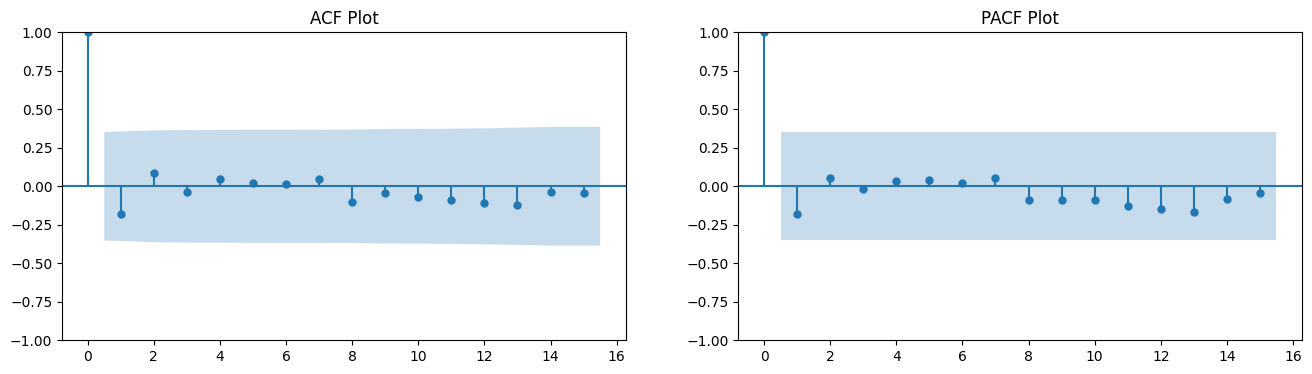

In [29]:


fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot (to find MA(q))
plot_acf(df_monthly_averages["price_EUR"].dropna(), ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot (to find AR(p))
plot_pacf(df_monthly_averages["price_EUR"].dropna(), ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()


Graph shows that AR seems to be the best fitting model type

### Testing of different AR(p) models

In [32]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1), AR(2), and AR(3) models
model_ar1 = AutoReg(df_monthly_averages["price_EUR"], lags=1).fit()
model_ar2 = AutoReg(df_monthly_averages["price_EUR"], lags=2).fit()
model_ar3 = AutoReg(df_monthly_averages["price_EUR"], lags=3).fit()

# Extract BIC values
bic_values = {
    "AR(1)": model_ar1.bic,
    "AR(2)": model_ar2.bic,
    "AR(3)": model_ar3.bic
}

# Display BIC scores
for model, bic in bic_values.items():
    print(f"{model} BIC: {bic}")

# Determine model with the lowest BIC
best_model = min(bic_values, key=bic_values.get)
print(f"\n✅ The model with the lowest BIC is: {best_model}")


AR(1) BIC: 609.7410347145676
AR(2) BIC: 569.9796023571203
AR(3) BIC: 551.1079197716571

✅ The model with the lowest BIC is: AR(3)


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### AR(3) for forecasting

In [33]:
# Forecast the next 12 periods (adjust as needed)
n_periods = 3
forecast = model_ar3.predict(
    start=len(df_monthly_averages),
    end=len(df_monthly_averages) + n_periods - 1,
    dynamic=False
)

# Create a future date range for the forecast
last_date = df_monthly_averages.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]

# Combine forecast with dates into a DataFrame
forecast_df = pd.DataFrame({'forecast': forecast.values}, index=future_dates)
forecast_df.head()


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,forecast
2023-01-31,35437.931656
2023-02-28,35046.860312
2023-03-31,34836.007583


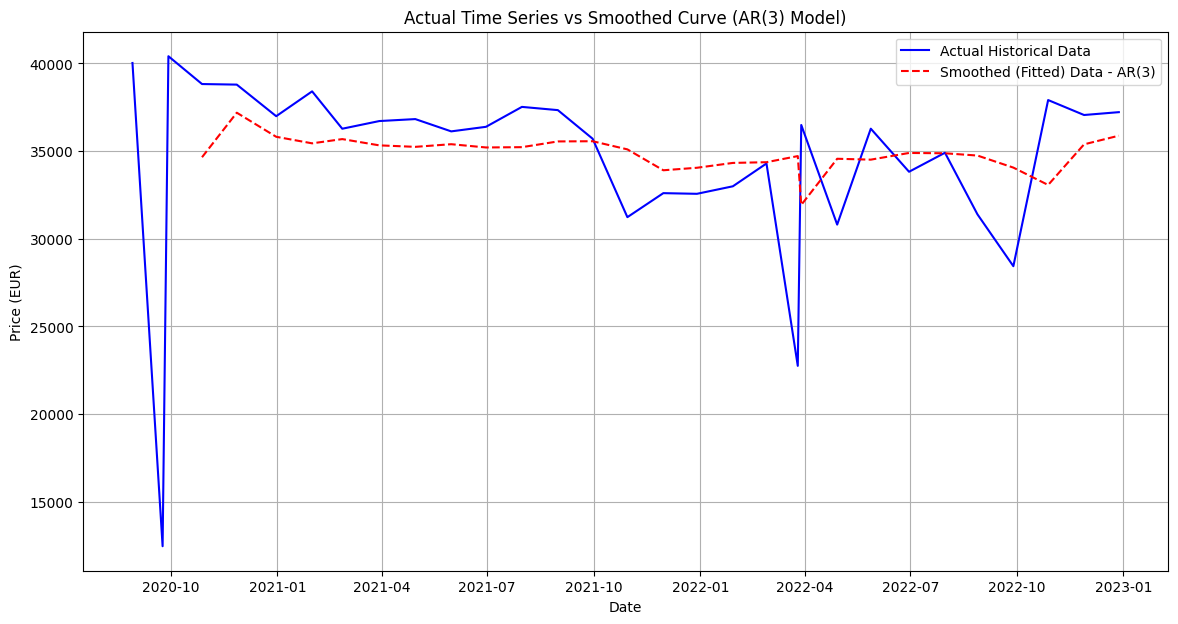

In [34]:
import matplotlib.pyplot as plt

# Get fitted values (smoothed series) for the historical period
fitted_values = model_ar3.fittedvalues

# Plot actual vs smoothed (fitted) data
plt.figure(figsize=(14, 7))
plt.plot(df_monthly_averages.index, df_monthly_averages["price_EUR"], label="Actual Historical Data", color="blue")
plt.plot(fitted_values.index, fitted_values.values, label="Smoothed (Fitted) Data - AR(3)", color="red", linestyle='--')

plt.title("Actual Time Series vs Smoothed Curve (AR(3) Model)")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.legend()
plt.grid(True)
plt.show()


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


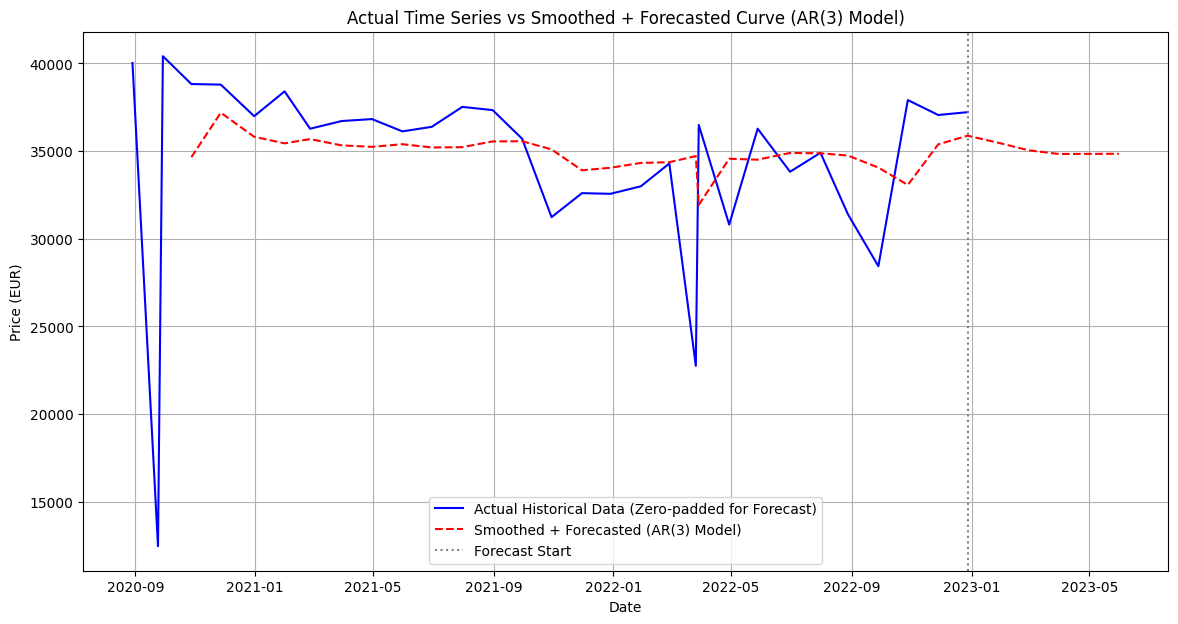

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get fitted values (smoothed series) for the historical period
# Fitted values start after the lag period, so we align them properly
fitted_values = model_ar3.fittedvalues
fitted_full = pd.Series(index=df_monthly_averages.index, dtype=float)
fitted_full[fitted_values.index] = fitted_values

# Step 2: Forecast the next 12 periods
n_periods = 5
forecast = model_ar3.predict(
    start=len(df_monthly_averages),
    end=len(df_monthly_averages) + n_periods - 1,
    dynamic=False
)

# Step 3: Create future dates for the forecast period
last_date = df_monthly_averages.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='M')

# Step 4: Adjust actual series by appending zeros for the forecast period
actual_extended = pd.concat([
    df_monthly_averages["price_EUR"],
    pd.Series(["NaN"] * n_periods, index=future_dates)
])

# Step 5: Combine smoothed (fitted) historical values and forecast
smoothed_forecast_series = pd.concat([fitted_full, forecast])

# Step 6: Ensure identical index lengths and alignment
smoothed_forecast_series.index = actual_extended.index  # Now both have exact same length

# Step 7: Plot actual, smoothed, and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(actual_extended.index, actual_extended.values, label="Actual Historical Data (Zero-padded for Forecast)", color="blue")
plt.plot(smoothed_forecast_series.index, smoothed_forecast_series.values, label="Smoothed + Forecasted (AR(3) Model)", color="red", linestyle='--')

plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title("Actual Time Series vs Smoothed + Forecasted Curve (AR(3) Model)")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.legend()
plt.grid(True)
plt.show()
